# Машинное обучение в бизнесе: выбор локации для скважины

**Описание проекта**

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Импорт библиотек**

In [1]:
!pip install --upgrade scikit-learn -q
!pip install phik -q


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import phik
import os

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC, SVR

from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

# класс для работы с пропусками
from sklearn.impute import SimpleImputer

from sklearn.metrics import (
    root_mean_squared_error,
    mean_squared_error
)

from sklearn.pipeline import Pipeline

from phik.report import plot_correlation_matrix


RANDOM_STATE = 42

## Загрузка, подготовка и исследовательский анализ данных

In [3]:
pth1 = f'/datasets/geo_data_0.csv'
pth2 = f'D:/Данные/geo_data_0.csv'
    
if os.path.exists(pth1):
    geo_data_0 = pd.read_csv(pth1)
elif os.path.exists(pth2):
    geo_data_0  = pd.read_csv(pth2)
else:
    print('Something is wrong')
    

pth1 = f'/datasets/geo_data_1.csv'
pth2 = f'D:/Данные/geo_data_1.csv'
    
if os.path.exists(pth1):
    geo_data_1 = pd.read_csv(pth1)
elif os.path.exists(pth2):
    geo_data_1  = pd.read_csv(pth2)
else:
    print('Something is wrong')
    
    
pth1 = f'/datasets/geo_data_2.csv'
pth2 = f'D:/Данные/geo_data_2.csv'
    
if os.path.exists(pth1):
    geo_data_2 = pd.read_csv(pth1)
elif os.path.exists(pth2):
    geo_data_2  = pd.read_csv(pth2)
else:
    print('Something is wrong')
    
    
for n in [geo_data_0, geo_data_1, geo_data_2]:
    display(n.head(2))
    display(n.tail(2))
    display(n.info())      

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.22117,105.280062
1,2acmU,1.334711,-0.340164,4.36508,73.037750


,id,f0,f1,f2,product
99998,7kl59,0.998163,-0.528582,1.583869,74.040764
99999,1CWhH,1.764754,-0.266417,5.722849,149.633246


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261


,id,f0,f1,f2,product
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364
99999,relB0,-3.426139,-7.794274,-0.003299,3.179103


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697


,id,f0,f1,f2,product
99998,nmxp2,-2.419896,2.417221,-5.548444,51.795253
99999,V9kWn,-2.551421,-2.025625,6.090891,102.775767


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

**Явные дубликаты**

In [4]:
for n in [geo_data_0, geo_data_1, geo_data_2]:
    display(f'Кол-во дубликатов {n.duplicated().sum()}')


'Кол-во дубликатов 0'

'Кол-во дубликатов 0'

'Кол-во дубликатов 0'

**Неявные дубликаты**

In [5]:
for n in [geo_data_0, geo_data_1, geo_data_2]:   
    print(n[n['id'].isin(n['id'][n['id'].duplicated()])].sort_values('id'))   
    print('-'* 50)


          id        f0        f1         f2     product
66136  74z30  1.084962 -0.312358   6.990771  127.643327
64022  74z30  0.741456  0.459229   5.153109  140.771492
51970  A5aEY -0.180335  0.935548  -2.094773   33.020205
3389   A5aEY -0.039949  0.156872   0.209861   89.249364
69163  AGS9W -0.933795  0.116194  -3.655896   19.230453
42529  AGS9W  1.454747 -0.479651   0.683380  126.370504
931    HZww2  0.755284  0.368511   1.863211   30.681774
7530   HZww2  1.061194 -0.373969  10.430210  158.828695
63593  QcMuo  0.635635 -0.473422   0.862670   64.578675
1949   QcMuo  0.506563 -0.323775  -2.215583   75.496502
75715  Tdehs  0.112079  0.430296   3.218993   60.964018
21426  Tdehs  0.829407  0.298807  -0.049563   96.035308
92341  TtcGQ  0.110711  1.022689   0.911381  101.318008
60140  TtcGQ  0.569276 -0.104876   6.440215   85.350186
89582  bsk9y  0.398908 -0.400253  10.122376  163.433078
97785  bsk9y  0.378429  0.005837   0.160827  160.637302
41724  bxg6G -0.823752  0.546319   3.630479   93

**Распределение признаков**

Функция для отрисовки графиков:

In [6]:
def draw_chart(n):
    for i, col in enumerate(n[['f0', 'f1', 'f2', 'product']]):        
        x_label = ('тыс. баррелей' if col in ['product'] 
                   else 'Кол-во единиц') 
        title_name = col[0].upper() + col[1:].lower()

        mean_value = n[col].mean()
        median_value = n[col].median()

        plt.figure(i)

        fig, axs = plt.subplots(nrows = 1 , ncols = 2, figsize = (12,4))

        sns.histplot(data = n, x = n[col], ax=axs[0], kde=True, bins = 50)
        axs[0].axvline(mean_value, linewidth=2, color='orange', alpha=1, linestyle='--', label = 'Среднее = {:.3f}'.format(mean_value))
        axs[0].axvline(median_value, linewidth=2, color='orange', alpha=1, linestyle='-', label = 'Медиана = {:.3f}'.format(median_value))
        axs[0].set_xlabel(x_label)
        axs[0].set_ylabel('Количество точек')
        axs[0].legend(fontsize="8")

        sns.boxplot(data = n, x = n[col], ax=axs[1])
        axs[1].set_xlabel(x_label)
        fig.suptitle(title_name)    


Функция для матрицы корреляции:

In [7]:
def draw_phik_matrix(dataframe):

    df_corr = dataframe.phik_matrix(interval_cols=['f0', 'f1', 'f2', 'product'])

    plot_correlation_matrix(
        df_corr.values,
        x_labels=df_corr.columns,
        y_labels=df_corr.index,
        vmin=0, vmax=1, color_map='Greens',
        title=r'correlation $\phi_K$',
        fontsize_factor=1.2,
        figsize=(15, 7)
    ) 

**Регион №1**   

In [8]:
geo_data_0.drop('id', axis=1).describe() 

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


<Figure size 432x288 with 0 Axes>

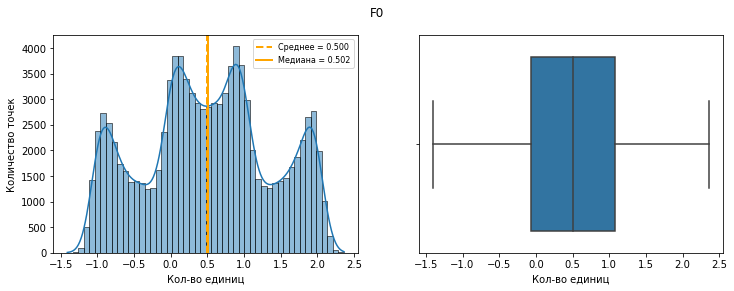

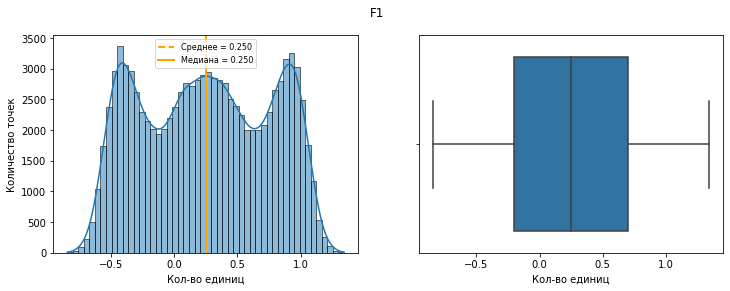

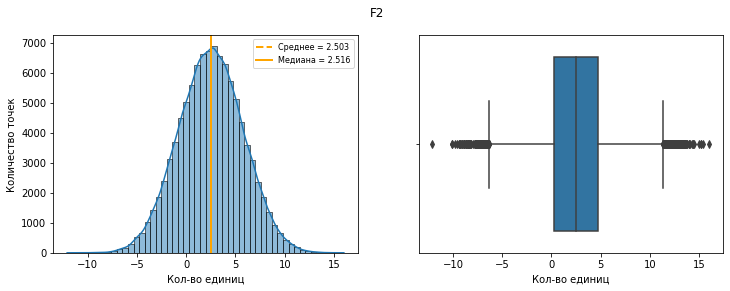

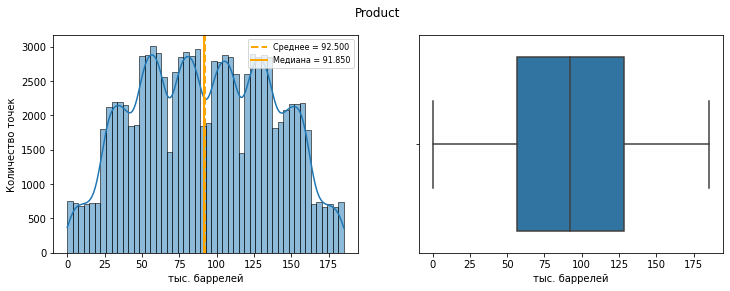

In [9]:
draw_chart(geo_data_0)

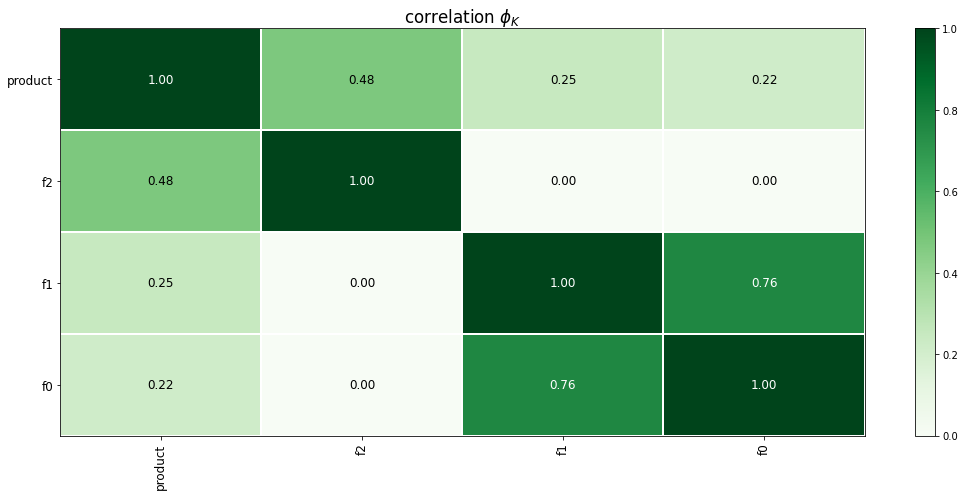

In [10]:
draw_phik_matrix(geo_data_0.drop(['id'], axis=1))

**Регион №2**

In [11]:
geo_data_1.drop('id', axis=1).describe() 

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


<Figure size 432x288 with 0 Axes>

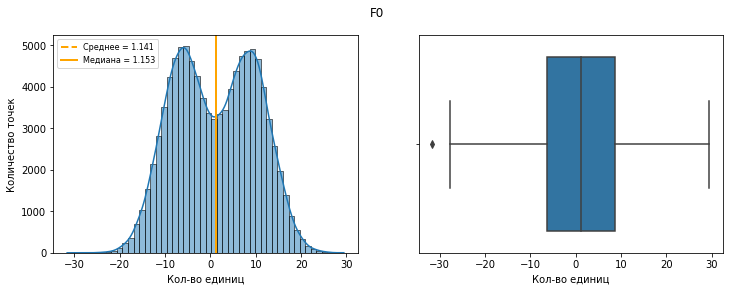

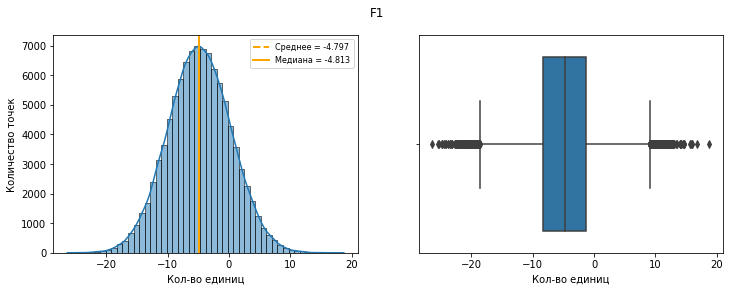

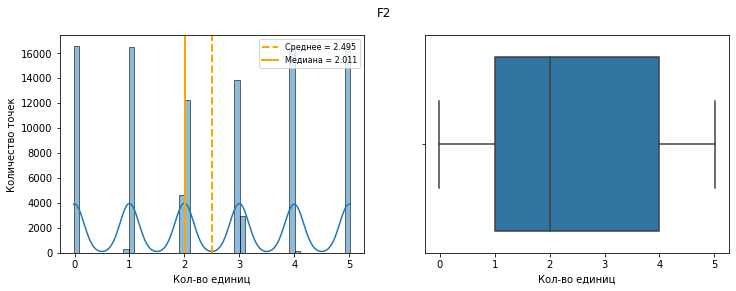

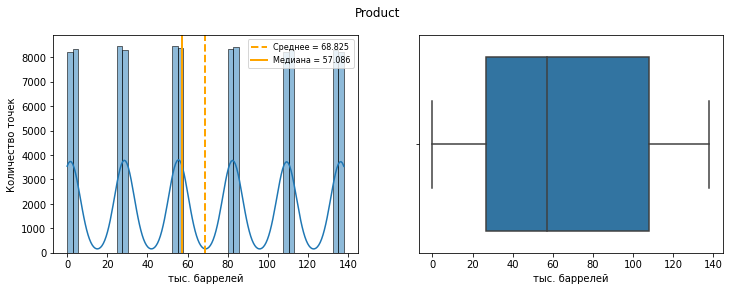

In [12]:
draw_chart(geo_data_1)

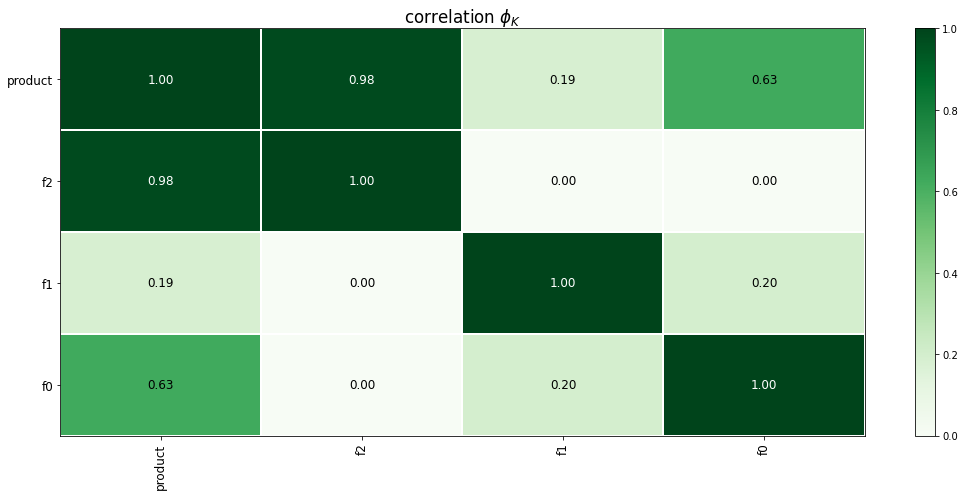

In [13]:
draw_phik_matrix(geo_data_1.drop(['id'], axis=1))

**Регион №3**

In [14]:
geo_data_2.drop('id', axis=1).describe() 

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


<Figure size 432x288 with 0 Axes>

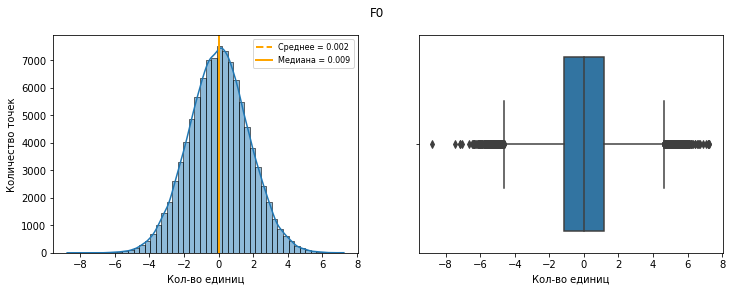

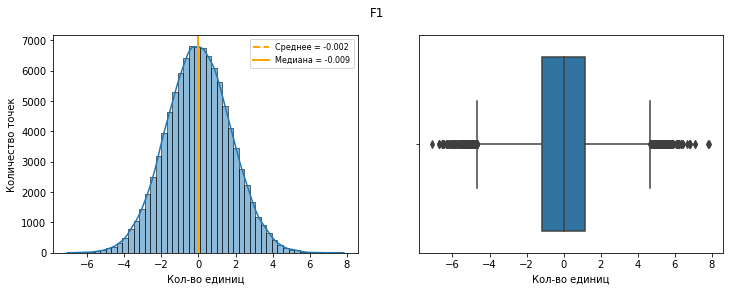

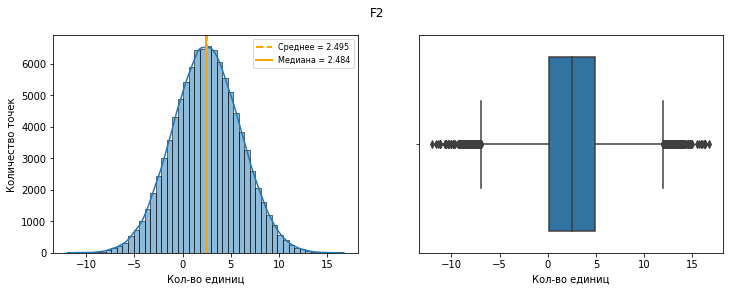

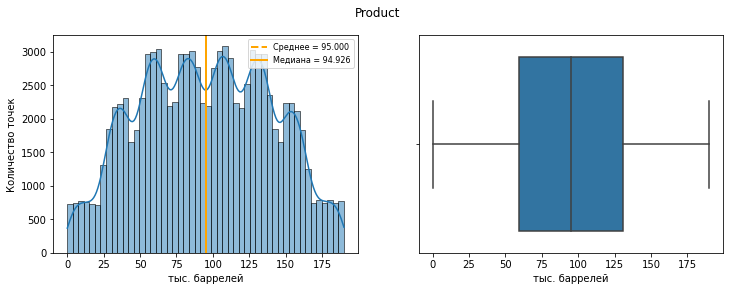

In [15]:
draw_chart(geo_data_2)

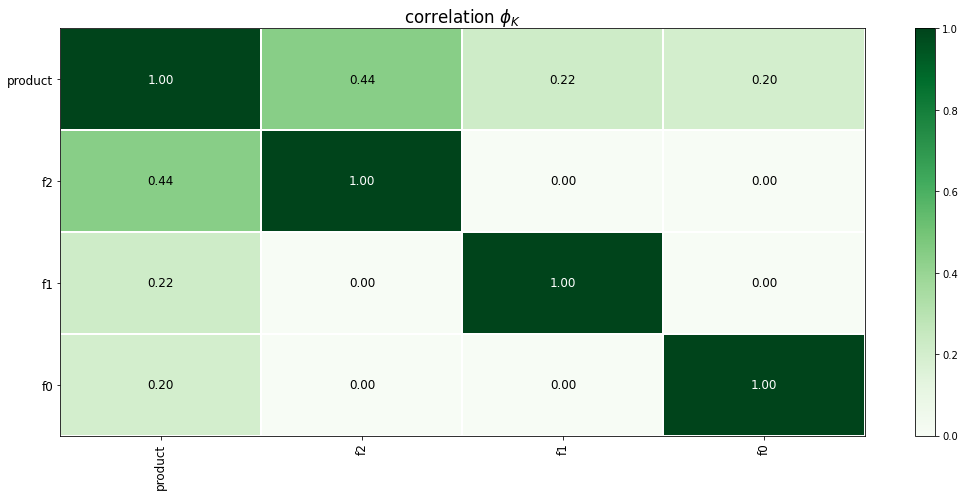

In [16]:
draw_phik_matrix(geo_data_2.drop(['id'], axis=1))

### Промежуточный вывод

После записи датасета в одноименные переменные `geo_data_0`, `geo_data_1`, `geo_data_2` и первичного знакомства с данными видим, что данные в таблицах соответствуют описанию. 

Данные не содержат пропуски и явные дубликаты.

В каждом из трех датафреймов содержатся повторяющиеся идентификаторы скважин, которые должны быть уникальными. При этом для скважин с одним идентификатором данные признаков и объемов запасов существенно различаются.
Во избежание упущенной выгоды в случае удаления дублей, оставим дубли. В реальной ситуации необходимо уточнение от заказчика для продолжения работы с данными.

Каждой датафрейм содержит 5 столбцов и 100 тыс. строк. Столбец с идентификатором скважины имеет строковый тип данных, стобцы с информацией о признаках и объеме добычи имеют вещественный тип данных.

Наименования столбцов в датафреймах соответствуют "змеиному" регистру.



`F0`:
- Распределение признака мультимодальное в 1м и 2м регионах, в 1м регионе - нет выбросов, во 2м регионе есть 1 выброс. В 3м регионе признак распределен нормально, присутсвуют выбросы как у нижней, так и у верхней границ распределения.
- Разброс значений отличается в зависимости от региона: от -1.4 до 2.4 в 1м регионе, от -31.6 до 29.4 в 2м регионе, от -8.8 до 7.2 в 3м регионе.

`F1`:
- Распределение признака мультимодальное в 1м регионе, нет выбросов. Во 2м регионе признак распределен нормально со сдвигом влево, в 3м регионе признак распределен нормально, присутсвуют выбросы как у нижней, так и у верхней границ распределения.
- Разброс значений отличается в зависимости от региона: от -0.8 до 1.3 в 1м регионе, от -26.4 до 18.7 в 2м регионе, от -7.1 до 7.8 в 3м регионе.

`F2`:
- В 1м и 3м регионах признак распределен нормально со сдвигом вправо, есть выбросы. Во 2м регионе признак сгруппирован по кластерам, нет выбросов.
- Разброс значений отличается в зависимости от региона: от -12.1 до 16 в 1м регионе, от -0.02 до 5.02 в 2м регионе, от -12 до 16.7 в 3м регионе.

`product`:
- Распределение признака мультимодальное в 1м и 3м регионах, без выбросов. Во 2м регионе признак сгруппирован по кластерам, нет выбросов.
- Разброс значений отличается в зависимости от региона: от 0 до 185.4 в 1м регионе, от 0 до 138 в 2м регионе, от 0 до 190 в 3м регионе.



Регион №1:

Целевой признак `product` коррелирует с признаками: 
    - `f2`- коэффициент корреляции: 0,48 - умеренная связь;
    - `f1` и `f0`- коэффициенты корреляции: 0,25 и 0,22 - слабая связь;

Мультиколлинеарности между входными признаками нет, самый высокий коэффициент корреляции 0,76 между признаками `f1` и `f0`.    

Регион №2:

Целевой признак `product` коррелирует с признаками: 
    - `f2`- коэффициент корреляции: 0,98 - весьма высокая связь;
    - `f1`- коэффициент корреляции: 0,19 - слабая связь;
    - `f0`- коэффициент корреляции: 0,63 - заметная связь;

Мультиколлинеарности между входными признаками нет. 

Регион №3:

Целевой признак `product` коррелирует с признаками: 
    - `f2`- коэффициент корреляции: 0,44 - умеренная связь;
    - `f1` и `f0`- коэффициенты корреляции: 0,22 и 0,20 - слабая связь;

Мультиколлинеарности между входными признаками нет. 


## Обучение и проверка модели

Функция для разбивки данных на обучающую и валидационную выборки в соотношении 75:25.

In [17]:
def prepare_data(df):

    X = df.drop(['product', 'id'], axis=1)
    y = df['product']

    X_train, X_test_valid, y_train, y_test_valid = train_test_split(X, y, \
    test_size=0.25, \
    random_state=RANDOM_STATE)
    
    display(f'X_train: {X_train.shape}', 
            f'X_test_valid: {X_test_valid.shape}',
            f'y_train: {y_train.shape}', 
            f'y_test_valid: {y_test_valid.shape}' )

    return X_train, X_test_valid, y_train, y_test_valid

Разбивка данных на обучающую и валидационную выборки для региона 1

In [18]:
X_train, X_test_valid, y_train, y_test_valid = prepare_data(geo_data_0)


'X_train: (75000, 3)'

'X_test_valid: (25000, 3)'

'y_train: (75000,)'

'y_test_valid: (25000,)'

Создание пайплайна для масштабирования количественных признаков и обучения модели

In [19]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', ColumnTransformer([('num', RobustScaler(), ['f0', 'f1', 'f2'])], remainder='passthrough')),
    ('models', LinearRegression( n_jobs= -1))
])

param_grid = [
   
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression(n_jobs= -1)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]


gs = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)


Создание пайплайна для масштабирования количественных признаков и обучения модели

Функция для обучения модели и получения предсказания на валидационной выборке, выводе среднего запаса предсказанного сырья и RMSE модели.

In [20]:
def prepare_data_2(X_train, X_test_valid, y_train, y_test_valid):

    gs.fit(X_train, y_train)

    print('Лучшая модель и её параметры:\n\n', gs.best_params_, '\n\n')

    pred = gs.predict(X_test_valid)
    
    pd.set_option('display.max_columns', None)
    display('Рейтинг моделей:',pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score').head())
        
    rmse_score = round(root_mean_squared_error(y_test_valid, pred), 5)
    pred_mean = pred.mean()
    y_valid = pd.concat([X_test_valid, y_test_valid], axis=1)
    y_valid['pred'] = pred
    
    return rmse_score, pred_mean, y_valid


Вывод метрик для региона № 1

In [21]:
rmse_score, pred_mean, y_valid_1 = prepare_data_2(X_train, X_test_valid, y_train, y_test_valid)

df_table = pd.DataFrame({'Регион, №': ['1'], 'Cредний запас сырья': pred_mean, 'RMSE': rmse_score})

display(df_table.style.set_caption('Данные по регионам на валидационных выборках'))

Лучшая модель и её параметры:

 {'models': LinearRegression(n_jobs=-1), 'preprocessor__num': StandardScaler()} 




'Рейтинг моделей:'

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_preprocessor__num,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.160335,0.060715,0.005994,0.000212,LinearRegression(n_jobs=-1),StandardScaler(),"{'models': LinearRegression(n_jobs=-1), 'prepr...",-37.267211,-37.698271,-37.979989,-37.733561,-37.680995,-37.672005,0.229465,1
1,0.155530,0.045299,0.040650,0.042468,LinearRegression(n_jobs=-1),MinMaxScaler(),"{'models': LinearRegression(n_jobs=-1), 'prepr...",-37.267211,-37.698271,-37.979989,-37.733561,-37.680995,-37.672005,0.229465,1
2,0.194526,0.004071,0.005580,0.000195,LinearRegression(n_jobs=-1),RobustScaler(),"{'models': LinearRegression(n_jobs=-1), 'prepr...",-37.267211,-37.698271,-37.979989,-37.733561,-37.680995,-37.672005,0.229465,1
3,0.151988,0.042769,0.023004,0.036654,LinearRegression(n_jobs=-1),passthrough,"{'models': LinearRegression(n_jobs=-1), 'prepr...",-37.267211,-37.698271,-37.979989,-37.733561,-37.680995,-37.672005,0.229465,1


,"Регион, №",Cредний запас сырья,RMSE
0,1,92.398800,37.756600


Разбивка данных на обучающую и валидационную выборки, обучение модели и выводе среднего запаса предсказанного сырья и RMSE модели для региона № 2.

In [22]:
X_train, X_test_valid, y_train, y_test_valid = prepare_data(geo_data_1)

rmse_score, pred_mean, y_valid_2 = prepare_data_2(X_train, X_test_valid, y_train, y_test_valid)

df_table = df_table.append({'Регион, №': '2', 'Cредний запас сырья': pred_mean, 'RMSE': rmse_score}, ignore_index=True)

display(df_table.style.set_caption('Данные по регионам на валидационных выборках'))


'X_train: (75000, 3)'

'X_test_valid: (25000, 3)'

'y_train: (75000,)'

'y_test_valid: (25000,)'

Лучшая модель и её параметры:

 {'models': LinearRegression(n_jobs=-1), 'preprocessor__num': StandardScaler()} 




'Рейтинг моделей:'

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_preprocessor__num,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.088259,0.025988,0.078570,0.035891,LinearRegression(n_jobs=-1),StandardScaler(),"{'models': LinearRegression(n_jobs=-1), 'prepr...",-0.886094,-0.890379,-0.893287,-0.892678,-0.889843,-0.890456,0.002544,1
1,0.119439,0.038859,0.060627,0.043755,LinearRegression(n_jobs=-1),MinMaxScaler(),"{'models': LinearRegression(n_jobs=-1), 'prepr...",-0.886094,-0.890379,-0.893287,-0.892678,-0.889843,-0.890456,0.002544,1
2,0.191978,0.002548,0.006211,0.000405,LinearRegression(n_jobs=-1),RobustScaler(),"{'models': LinearRegression(n_jobs=-1), 'prepr...",-0.886094,-0.890379,-0.893287,-0.892678,-0.889843,-0.890456,0.002544,1
3,0.097032,0.056796,0.040380,0.042699,LinearRegression(n_jobs=-1),passthrough,"{'models': LinearRegression(n_jobs=-1), 'prepr...",-0.886094,-0.890379,-0.893287,-0.892678,-0.889843,-0.890456,0.002544,4


,"Регион, №",Cредний запас сырья,RMSE
0,1,92.398800,37.756600
1,2,68.712878,0.890280


Разбивка данных на обучающую и валидационную выборки, обучение модели и выводе среднего запаса предсказанного сырья и RMSE модели для региона № 3.

In [23]:
X_train, X_test_valid, y_train, y_test_valid = prepare_data(geo_data_2)

rmse_score, pred_mean, y_valid_3 = prepare_data_2(X_train, X_test_valid, y_train, y_test_valid)

df_table = df_table.append({'Регион, №': '3', 'Cредний запас сырья': pred_mean, 'RMSE': rmse_score}, ignore_index=True)

display(df_table.style.set_caption('Данные по регионам на валидационных выборках'))


'X_train: (75000, 3)'

'X_test_valid: (25000, 3)'

'y_train: (75000,)'

'y_test_valid: (25000,)'

Лучшая модель и её параметры:

 {'models': LinearRegression(n_jobs=-1), 'preprocessor__num': StandardScaler()} 




'Рейтинг моделей:'

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_preprocessor__num,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.074906,0.035118,0.077515,0.036421,LinearRegression(n_jobs=-1),StandardScaler(),"{'models': LinearRegression(n_jobs=-1), 'prepr...",-40.004724,-40.110065,-39.986828,-39.909902,-40.123389,-40.026982,0.080016,1
1,0.102560,0.002376,0.078644,0.034379,LinearRegression(n_jobs=-1),MinMaxScaler(),"{'models': LinearRegression(n_jobs=-1), 'prepr...",-40.004724,-40.110065,-39.986828,-39.909902,-40.123389,-40.026982,0.080016,1
2,0.192591,0.003197,0.005738,0.000109,LinearRegression(n_jobs=-1),RobustScaler(),"{'models': LinearRegression(n_jobs=-1), 'prepr...",-40.004724,-40.110065,-39.986828,-39.909902,-40.123389,-40.026982,0.080016,1
3,0.098676,0.054653,0.057493,0.042575,LinearRegression(n_jobs=-1),passthrough,"{'models': LinearRegression(n_jobs=-1), 'prepr...",-40.004724,-40.110065,-39.986828,-39.909902,-40.123389,-40.026982,0.080016,1


,"Регион, №",Cредний запас сырья,RMSE
0,1,92.398800,37.756600
1,2,68.712878,0.890280
2,3,94.771024,40.145870


### Промежуточный вывод

Корень среднеквадратичной ошибки показывает, на какое значение предсказание в среднем отличается от истинного значения. Значение метрики ниже для региона № 2 и составляет 0.89 тыс. баррелей. Вместе с этим средний запас сырья в этом регионе самый низкий - 68,7 тыс. баррелей.

Самый высокий средний запас сырья в регионе № 3 - 94,8 тыс. баррелей, при этом значение метрики RMSE самое высокое - 40 тыс. баррелей.  

## Подготовка к расчёту прибыли

Сохранение ключевых значений для расчётов в отдельных переменных.

In [24]:
DEVELOPMENT_BUDGET = 10000000000
INCOME_PER_UNIT = 450000
PROBABILITY_OF_LOSS = 0.025
TOTAL_POINTS = 500
BEST_POINTS = 200

In [25]:
development_volume = DEVELOPMENT_BUDGET / INCOME_PER_UNIT / BEST_POINTS

print('Достаточный объём сырья для безубыточной разработки новой скважины: ', development_volume, '\n'
     'Полученный объём сырья превышает средний запас сырья в каждом регионе.')


Достаточный объём сырья для безубыточной разработки новой скважины:  111.11111111111111 
Полученный объём сырья превышает средний запас сырья в каждом регионе.


## Функция для расчёта прибыли

Функция расчета прибыли для 200 лучших для разработки скважин.

In [26]:
def profit_calc(subsample):
    profit = (subsample.sort_values(by='pred', ascending = False)
              .head(BEST_POINTS)['product']
              .sum() * INCOME_PER_UNIT - DEVELOPMENT_BUDGET)
    return profit

## Расчёт прибыли и рисков 

Функция для применения техники Bootstrap с 1000 выборок и распределение прибыли.
Для каждой выборки нахождение средней прибыли, 95%-го доверительного интервала и риска убытков.


In [27]:
def sample_calc(df):

    state = np.random.RandomState(12345)
    values = []

    for i in range(1000):
        subsample = df.sample(n=500, replace=True, random_state=state) 
        profit_value = profit_calc(subsample)
        values.append(profit_value)

    values = pd.Series(values)
    
    mean_profit = f'{int(values.mean()):,}'
    risk_of_loss = round((values < 0).sum() / 1000 * 100, 1)
    confidence_interval = (f"{int(values.quantile(0.025)):,} ; {int(values.quantile(0.975)):,}") 

    return [mean_profit, confidence_interval, risk_of_loss]


In [28]:
ind = []

for n in [y_valid_1, y_valid_2, y_valid_3] :
    ind.append(sample_calc(n))

In [29]:
df = pd.DataFrame(ind, columns=['Средняя прибыль, р.', '95%-й доверительный интервал, р.', 'Риск убытков, %'])
df

,"Средняя прибыль, р.","95%-й доверительный интервал, р.","Риск убытков, %"
0,"406,278,783","-117,742,136 ; 911,737,050",6.7
1,"432,624,131","16,846,174 ; 815,972,526",1.9
2,"377,362,192","-170,780,417 ; 901,772,131",7.4


### Промежуточный вывод

Лучший регион для разработки скважин - регион № 2.
Вероятность убытков ниже 2.5% и составляет 1.9 %. Средняя прибыль в этом регионе выше по сравнению с другими регионами и составляет 432,6 млн р. 95%-й доверительный интервал в распределении прибыли от 16,8 млн р. до 816 млн р.

## Общий вывод

`Цель исследования`: На основе данных качества нефти и объёма её запасов в трёх регионах построена модель для предсказания объёма запасов в новых скважинах в каждом регионе. Проанализирована возможная прибыль и риски техникой Bootstrap. Определен регион с минимальной вероятностью убытков и максимальной суммарной прибылью отобранных скважин - регион № 2.

Вероятность убытков ниже 2.5% и составляет 1.9 %. Средняя прибыль в этом регионе выше по сравнению с другими регионами и составляет 432,6 млн р. 95%-й доверительный интервал в распределении прибыли от 16,8 млн р. до 816 млн р.


`Исходные данные` содержат информацию о качестве нефти и объёме её запасов в трёх регионах.


`Подготовка и исследовательский анализ данных` включает этапы:
- Запись датасета в переменные;
- Явные дубликаты и пропуски не обнаружены.
- Обнаружены повторяющиеся идентификаторы скважин с отличными друг от друга объемами запасов.
Дубли оставлены. В реальной ситуации необходимо уточнение от заказчика для продолжения работы с данными.
- Распределение целевого и входных признаков отличается от региона к региону.

`F0`:
- Распределение признака мультимодальное в 1м и 2м регионах, в 1м регионе - нет выбросов, во 2м регионе есть 1 выброс. В 3м регионе признак распределен нормально, присутсвуют выбросы как у нижней, так и у верхней границ распределения.
- Разброс значений отличается в зависимости от региона: от -1.4 до 2.4 в 1м регионе, от -31.6 до 29.4 в 2м регионе, от -8.8 до 7.2 в 3м регионе.

`F1`:
- Распределение признака мультимодальное в 1м регионе, нет выбросов. Во 2м регионе признак распределен нормально со сдвигом влево, в 3м регионе признак распределен нормально, присутсвуют выбросы как у нижней, так и у верхней границ распределения.
- Разброс значений отличается в зависимости от региона: от -0.8 до 1.3 в 1м регионе, от -26.4 до 18.7 в 2м регионе, от -7.1 до 7.8 в 3м регионе.

`F2`:
- В 1м и 3м регионах признак распределен нормально со сдвигом вправо, есть выбросы. Во 2м регионе признак сгруппирован по кластерам, нет выбросов.
- Разброс значений отличается в зависимости от региона: от -12.1 до 16 в 1м регионе, от -0.02 до 5.02 в 2м регионе, от -12 до 16.7 в 3м регионе.

`product`:
- Распределение признака мультимодальное в 1м и 3м регионах, без выбросов. Во 2м регионе признак сгруппирован по кластерам, нет выбросов.
- Разброс значений отличается в зависимости от региона: от 0 до 185.4 в 1м регионе, от 0 до 138 в 2м регионе, от 0 до 190 в 3м регионе.

- Мультиколлинеарности между входными признаками нет. 

Регион №1:

Целевой признак `product` коррелирует с признаками: 
    - `f2`- коэффициент корреляции: 0,48 - умеренная связь;
    - `f1` и `f0`- коэффициенты корреляции: 0,25 и 0,22 - слабая связь;

Регион №2:

Целевой признак `product` коррелирует с признаками: 
    - `f2`- коэффициент корреляции: 0,98 - весьма высокая связь;
    - `f1`- коэффициент корреляции: 0,19 - слабая связь;
    - `f0`- коэффициент корреляции: 0,63 - заметная связь;

Регион №3:

Целевой признак `product` коррелирует с признаками: 
    - `f2`- коэффициент корреляции: 0,44 - умеренная связь;
    - `f1` и `f0`- коэффициенты корреляции: 0,22 и 0,20 - слабая связь;

`Обучение и проверка модели`

Обучена модель линейной регресии для каждого региона. 
Предсказание в среднем отличается от истинного значения меньше для региона № 2 и составляет 0.89 тыс. баррелей. Вместе с этим средний запас сырья в этом регионе самый низкий - 68,7 тыс. баррелей. 

Самый высокий средний запас сырья в регионе № 3 - 94,8 тыс. баррелей, при этом значение метрики RMSE самое высокое - 40 тыс. баррелей. 

Достаточный объём сырья для безубыточной разработки новой скважины:  111 тыс. баррелей. 
Он превышает средний запас сырья в каждом регионе.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован